In [1]:
from __future__ import print_function
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import tensorflow as tf
import pandas as pd
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
np.random.seed(1)
tf.random.set_seed(2)

NGRAMS = 2
FEATURE_LEN = 128
EPOCHS = 15
SAMPLES = 50000

Using TensorFlow backend.


In [2]:
adf = pd.read_csv('../train-test/data/top-1m.csv.zip', header=None, nrows=SAMPLES)
adf.columns = ['rank', 'domain']
adf = adf[['domain']]
adf

,domain
0,google.com
1,youtube.com
2,facebook.com
3,baidu.com
4,wikipedia.org
...,...
49995,reblop.com
49996,tiching.com
49997,akdeniz.edu.tr
49998,labporn.com


In [3]:
adf['malware_cat'] = 0
adf

,domain,malware_cat
0,google.com,0
1,youtube.com,0
2,facebook.com,0
3,baidu.com,0
4,wikipedia.org,0
...,...,...
49995,reblop.com,0
49996,tiching.com,0
49997,akdeniz.edu.tr,0
49998,labporn.com,0


In [4]:
# Malware Domain
df = pd.read_csv('../train-test/data/malware_2017.csv.bz2', usecols=['domain'])
df['malware_cat'] = 1
#df = df.sample(SAMPLES, random_state=21)

In [5]:
df

,domain,malware_cat
0,amazon.co.uk.security-check.ga,1
1,autosegurancabrasil.com,1
2,dadossolicitado-antendimento.sad879.mobi,1
3,hitnrun.com.my,1
4,maruthorvattomsrianjaneyatemple.org,1
...,...,...
15233,windowspeed.top,1
15234,wvw2-itunes.com,1
15235,yoursmartservice.ru,1
15236,yourtableteshop.eu,1


In [6]:
sdf = pd.concat([adf, df])
sdf

,domain,malware_cat
0,google.com,0
1,youtube.com,0
2,facebook.com,0
3,baidu.com,0
4,wikipedia.org,0
...,...,...
15233,windowspeed.top,1
15234,wvw2-itunes.com,1
15235,yoursmartservice.ru,1
15236,yourtableteshop.eu,1


## Preprocessing the input data

In [7]:
# build n-gram list
#vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=3, ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
vect = CountVectorizer(analyzer='char', ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
a = vect.fit_transform(sdf.domain)
vocab = vect.vocabulary_

# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = [w[1] for w in words]
num_words = len(words_list)
print("num_words = %d" % num_words)


def find_ngrams(text, n):
    a = zip(*[text[i:] for i in range(n)])
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(sdf.domain.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

num_words = 1448


In [8]:
print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
y = sdf.malware_cat

# Split train and test dataset
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
#X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Max feature len = 209, Avg. feature len = 13


In [9]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 10000, 1: 3048}

In [10]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 40000, 1: 12190}

## Train a LSTM model

In [11]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

max_features = num_words # 20000
feature_len = FEATURE_LEN # avg_feature_len # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


52190 train sequences
13048 test sequences
Pad sequences (samples x time)
X_train shape: (52190, 128)
X_test shape: (13048, 128)


In [12]:
# Function to create model, required for KerasClassifier
def create_model():
    print('Build model...')
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=feature_len))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(1, activation='sigmoid'))

    # try using different optimizers and different optimizer configs
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    #print(model.summary())
    return model

In [13]:
import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.linear_model import LogisticRegression

model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=batch_size, verbose=1)

Logistic:
	Brier: 0.141
	Precision: 0.789
	Recall: 0.281
	F1: 0.415

Build model...
Epoch 1/15
52190/52190 [==============================] - 223s 4ms/step - loss: 0.4075 - accuracy: 0.8285
Epoch 2/15
52190/52190 [==============================] - 222s 4ms/step - loss: 0.3685 - accuracy: 0.8487
Epoch 3/15
52190/52190 [==============================] - 221s 4ms/step - loss: 0.3577 - accuracy: 0.8531
Epoch 4/15
52190/52190 [==============================] - 221s 4ms/step - loss: 0.3500 - accuracy: 0.8560
Epoch 5/15
52190/52190 [==============================] - 222s 4ms/step - loss: 0.3431 - accuracy: 0.8585
Epoch 6/15
52190/52190 [==============================] - 247s 5ms/step - loss: 0.3365 - accuracy: 0.8626
Epoch 7/15
52190/52190 [==============================] - 303s 6ms/step - loss: 0.3304 - accuracy: 0.8658
Epoch 8/15
52190/52190 [==============================] - 312s 6ms/step - loss: 0.3254 - accuracy: 0.8683
Epoch 9/15
52190/52190 [==============================] - 313s 6ms/s

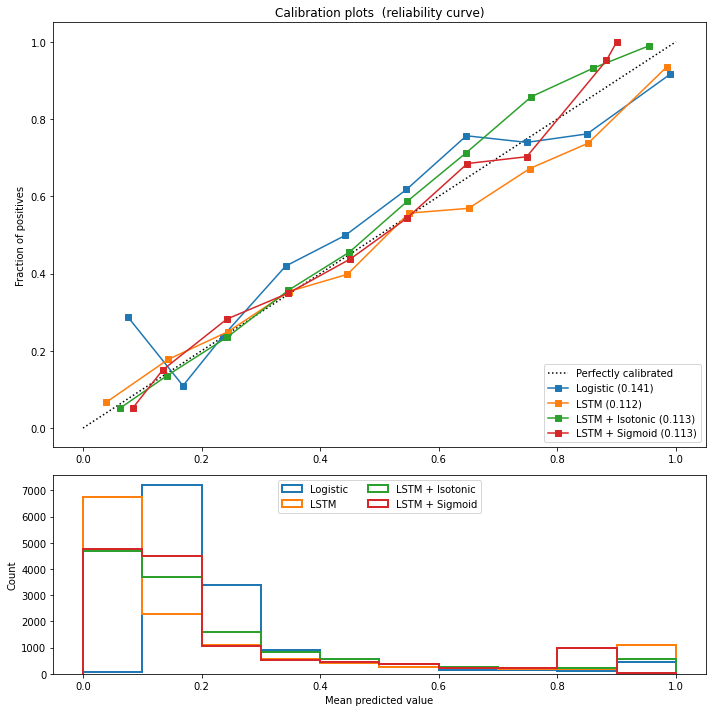

In [14]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for LSTM
plot_calibration_curve(model, "LSTM", 1)

plt.show()

## Confusion Matrix

In [15]:
y_pred = model.predict(X_test, verbose=1)
y_probs = model.predict_proba(X_test, verbose=1) # to predict probability
target_names = list(sdf.malware_cat.astype('category').cat.categories)

13048/13048 [==============================] - 22s 2ms/step


In [16]:
target_names = [str(t) for t in target_names]
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))    

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     10000
           1       0.80      0.51      0.62      3048

    accuracy                           0.86     13048
   macro avg       0.83      0.73      0.77     13048
weighted avg       0.85      0.86      0.84     13048

[[9608  392]
 [1496 1552]]


## Save model